# Date & time in pandas

Topics we will cover:
* Converting datetime columns
* Date and time as index
* Computing statistics using dates & time
* Shift
* Resampling
* .dt accessor


For this notebook we will use some data we downloaded from data.amsterdam.nl, which is a super useful website for getting open source data about Amsterdam! It's about the airquality in Amsterdam.

We have downloaded data from 01/01/2019 until 04/11/2019 for the location Amsterdam Vondelpark. It contains data about 7 airquality components: carbon monoxide (CO), nitric oxide (NO), ozone (O3),  fluorine nitrogen (FN), particulate matter (PM10 and PM25), nitrogen dioxide (NO2). It also contains a column called 'airquality_index' which is an index from 1 to 11 representing the public health impact of air pollution (1 = low risk, 11 = very high risk).

Link to data:
https://data.amsterdam.nl/datasets/Jlag-G3UBN4sHA/luchtkwaliteit/

More information on the data and airquality:
https://www.luchtmeetnet.nl/uitleg

## 0. Load data

In [1]:
import datetime
import matplotlib
import pandas as pd

%matplotlib inline

In [2]:
airquality = pd.read_csv("../workshop/data/airquality.csv", delimiter=";", decimal=",")

# rename columns from Dutch to English
airquality.columns = ["time", "location", "component", "value", "airquality_index"]

In [3]:
airquality.shape

(45459, 5)

In [4]:
airquality.head(2)

,time,location,component,value,airquality_index
0,2019-01-01 01:00:00+01:00,Amsterdam-Vondelpark,CO,298.1,2
1,2019-01-01 01:00:00+01:00,Amsterdam-Vondelpark,NO,5.2,1


We can already foresee a problem here looking at the time column, namely that it appears to have a timezone

In [5]:
airquality.dtypes

time                 object
location             object
component            object
value               float64
airquality_index      int64
dtype: object

Note that the time column is inferred as an 'object' column by pandas

## 1. Converting timestamp columns

### 1.1 String to timestamp

In [6]:
# Try to convert the 'time' column to a datetime column using pd.to_datetime

airquality["time"] = pd.to_datetime(airquality["time"])

You could get the following error:

`ValueError: Tz-aware datetime.datetime cannot be converted to datetime64 unless utc=True`

You can read more about timezones & pandas here: https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#time-zone-handling

Let's try to convert the time column again, now using utc=True. Also, let's do it in a nicer way by specifying a format. In addition to the required datetime string, you can pass a format argument to ensure specific parsing. This could also potentially speed up the conversion considerably.

You can find an overview of formats here: https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior

In [21]:
time_col = ["time"]

def convert_to_datetime(col, fmt = "%Y-%m-%d %H:%M:%S"):
    return pd.to_datetime(col, format=fmt, utc=True)

airquality[time_col] = airquality[time_col].apply(convert_to_datetime)

print(airquality.dtypes)

airquality.head(2)

time                datetime64[ns, UTC]
location                         object
component                        object
value                           float64
airquality_index                  int64
dtype: object


,time,location,component,value,airquality_index
0,2019-01-01 00:00:00+00:00,Amsterdam-Vondelpark,CO,298.1,2
1,2019-01-01 00:00:00+00:00,Amsterdam-Vondelpark,NO,5.2,1


Great! Now we have our time column in UTC time and the type of column is datetime64. Pandas datetime columns are always of type `datetime64[ns]` or `datetime64[ns, tz]`.

In [22]:
# You can easily convert to other timezones in this way:
airquality.time.dt.tz_convert('US/Pacific')

0       2018-12-31 16:00:00-08:00
1       2018-12-31 16:00:00-08:00
2       2018-12-31 16:00:00-08:00
3       2018-12-31 16:00:00-08:00
4       2018-12-31 16:00:00-08:00
                   ...           
45454   2019-09-30 16:00:00-07:00
45455   2019-09-30 16:00:00-07:00
45456   2019-09-30 16:00:00-07:00
45457   2019-09-30 16:00:00-07:00
45458   2019-11-04 05:00:00-08:00
Name: time, Length: 45459, dtype: datetime64[ns, US/Pacific]

In [23]:
# Try to remove the timezone information completely.
# Save the dataframe and move on to the next section!

airquality.time = airquality.time.dt.tz_convert(None)
print(airquality.sample(2))

                     time              location component  value  \
25631 2019-06-03 19:00:00  Amsterdam-Vondelpark        NO    0.0   
10723 2019-03-06 18:00:00  Amsterdam-Vondelpark        NO    0.5   

       airquality_index  
25631                 1  
10723                 1  


### 1.2 Datetime to string

There might be reasons for you to want to convert from timestamp back to string. In that case you can use **datetime.strftime**.

In [24]:
# make a copy of the dataframe so we do not alter our original one.
airquality_temp = airquality.copy()

airquality_temp["time"] = airquality_temp["time"].apply(
    lambda x: datetime.datetime.strftime(x, format="%Y-%m-%d %H:%M:%S")
)

# check results
print(airquality_temp.head(2))
print(airquality_temp.dtypes)

                  time              location component  value  \
0  2019-01-01 00:00:00  Amsterdam-Vondelpark        CO  298.1   
1  2019-01-01 00:00:00  Amsterdam-Vondelpark        NO    5.2   

   airquality_index  
0                 2  
1                 1  
time                 object
location             object
component            object
value               float64
airquality_index      int64
dtype: object


### 1.3 Handling errors

Several errors can happen when you try to convert a column to datetime.
Pandas lists three ways to deal with them:
- `errors='raise'` raise when unparseable
- `errors='ignore'` return original input when unparseable
- `errors='coerce'` convert unparseable data to `NaT` (not a time)

Let's add some errors to our data by changing the timestamp of the first row to a string.

In [45]:
airquality_errors = airquality.copy()
airquality_errors.time.iloc[0] = "not a time"
print(airquality_errors.iloc[0])

In [49]:
# now try to convert the time column, and try some different options for the errors.
print(pd.to_datetime(airquality_errors["time"], errors="coerce"))
print(pd.to_datetime(airquality_errors["time"], errors="ignore"))
print(pd.to_datetime(airquality_errors["time"], errors="raise"))

0                       NaT
1       2019-01-01 00:00:00
2       2019-01-01 00:00:00
3       2019-01-01 00:00:00
4       2019-01-01 00:00:00
                ...        
45454   2019-09-30 23:00:00
45455   2019-09-30 23:00:00
45456   2019-09-30 23:00:00
45457   2019-09-30 23:00:00
45458   2019-11-04 13:00:00
Name: time, Length: 45459, dtype: datetime64[ns]


In [49]:
# now try to convert a column with numbers, say 'value', and see what happens
print(pd.to_datetime(airquality["value"]))

0       1970-01-01 00:00:00.000000298
1       1970-01-01 00:00:00.000000005
2       1970-01-01 00:00:00.000000030
3       1970-01-01 00:00:00.000000003
4       1970-01-01 00:00:00.000000425
                     ...             
45454   1970-01-01 00:00:00.000000266
45455   1970-01-01 00:00:00.000000000
45456   1970-01-01 00:00:00.000000018
45457   1970-01-01 00:00:00.000000023
45458   1970-01-01 00:00:00.000000186
Name: value, Length: 45459, dtype: datetime64[ns]


That's pretty odd! No matter what error option we specify, the column will still be converted to unix timestamp!


The main take-away is that converting columns to datetime can be tricky, and you should always be careful when doing so. It's important to check you columns before and after, to make sure the converting succeeded.

### 1.4 Timestamp to epoch

As we saw before, Pandas can convert a column to unix timestamp. The unix time stamp is a way to track time as a running total of seconds since the epoch. Pandas stores timestamp with nanoseconds resolution. The epoch is defined as January 1st, 1970 at UTC.

In [57]:
# convert our column 'time' from timestamp to unix time
# 1) make a new column 'time_unix', 
# 2) cast the timestamp to integer using .astype(int), 
# 3) convert the column from nanoseconds to seconds

airquality["time_unix"] = airquality.time.astype(int) / 1e9
print(airquality[["time", "time_unix"]].sample(3))

                     time     time_unix
40758 2019-09-02 18:00:00  1.567447e+09
4092  2019-01-26 01:00:00  1.548464e+09
10868 2019-03-07 14:00:00  1.551967e+09


### 1.5 Creating timestamps

You can create your own Pandas timestamps in several ways

In [63]:
# Use `datetime.datetime` and `pd.Timestamp` to create a Pandas timestamp
pd.Timestamp(datetime.datetime(2019,11,28))

Timestamp('2019-11-28 00:00:00')

In [59]:
# Use plain strings
pd.Timestamp('2018-01-05')

Timestamp('2018-01-05 00:00:00')

In [60]:
# Or just use `pd.Timestamp` as is
pd.Timestamp(2012, 5, 1)

Timestamp('2012-05-01 00:00:00')

In [61]:
# Generate sequences of fixed-frequency dates and time spans
pd.date_range('2018-01-01', periods=3, freq='H')

DatetimeIndex(['2018-01-01 00:00:00', '2018-01-01 01:00:00',
               '2018-01-01 02:00:00'],
              dtype='datetime64[ns]', freq='H')

In [62]:
pd.period_range('1/1/2011', freq='M', periods=3)

PeriodIndex(['2011-01', '2011-02', '2011-03'], dtype='period[M]', freq='M')

Try to create some example dataframes with different indexes, which you create by using the options above!

In [64]:
example_index = pd.date_range('2018-01-01', periods=3, freq='H')
pd.DataFrame({"a": [1,2,3], "b": [4,5,6]}, index=example_index)

,a,b
2018-01-01 00:00:00,1,4
2018-01-01 01:00:00,2,5
2018-01-01 02:00:00,3,6


In [65]:
example_index = pd.period_range('1/1/2011', freq='M', periods=12)
pd.DataFrame({"a": [100]*12, "b": [200]*12}, index=example_index)

,a,b
2011-01,100,200
2011-02,100,200
2011-03,100,200
2011-04,100,200
2011-05,100,200
2011-06,100,200
2011-07,100,200
2011-08,100,200
2011-09,100,200
2011-10,100,200


## 2. Use datetime as index

Now that we succesfully converted our column to datetime we can do some useful stuff with it! One of which is to set our datetime column as the index of our dataframe. Pros according to Pandas:
* A large range of dates for various offsets are pre-computed and cached under the hood in order to make generating subsequent date ranges very fast (just have to grab a slice).
* Fast shifting using the `shift` and `tshift` method on pandas objects.
* Unioning of overlapping `DatetimeIndex` objects with the same frequency is very fast (important for fast data alignment).
* Quick access to date fields via properties such as `year`, `month`, etc.
* Regularization functions like `snap` and very fast `asof` logic.


In [93]:
# Make a copy of our origin dataframe
# Filter the dataframe on component == "CO"
# Set the datetime column as an index of your dataframe
airquality_indexed = airquality.copy()
airquality_indexed = airquality_indexed.loc[airquality_indexed.component == "CO"]
airquality_indexed = airquality_indexed.set_index("time")

In [94]:
airquality_indexed.sample(2)

,location,component,value,airquality_index,time_unix
time,,,,,
2019-03-16 18:00:00,Amsterdam-Vondelpark,CO,296.4,2,1.552759e+09
2019-04-13 18:00:00,Amsterdam-Vondelpark,CO,303.1,2,1.555178e+09


In [95]:
# you can use one date to index
airquality_indexed.loc[datetime.datetime(2019,1,1),:]

location            Amsterdam-Vondelpark
component                             CO
value                              298.1
airquality_index                       2
time_unix                     1.5463e+09
Name: 2019-01-01 00:00:00, dtype: object

In [96]:
# you can also use strings
airquality_indexed.loc["2019-01-01"]

,location,component,value,airquality_index,time_unix
time,,,,,
2019-01-01 00:00:00,Amsterdam-Vondelpark,CO,298.1,2,1.546301e+09
2019-01-01 01:00:00,Amsterdam-Vondelpark,CO,287.7,2,1.546304e+09
2019-01-01 02:00:00,Amsterdam-Vondelpark,CO,244.6,1,1.546308e+09
2019-01-01 03:00:00,Amsterdam-Vondelpark,CO,219.9,1,1.546312e+09
2019-01-01 04:00:00,Amsterdam-Vondelpark,CO,214.5,1,1.546315e+09
2019-01-01 05:00:00,Amsterdam-Vondelpark,CO,207.9,1,1.546319e+09
2019-01-01 06:00:00,Amsterdam-Vondelpark,CO,202.4,1,1.546322e+09
2019-01-01 07:00:00,Amsterdam-Vondelpark,CO,200.6,1,1.546326e+09
2019-01-01 08:00:00,Amsterdam-Vondelpark,CO,216.5,1,1.546330e+09


In [97]:
# you can also slice the dataframe
airquality_indexed.loc[:datetime.datetime(2019,1,7)]

,location,component,value,airquality_index,time_unix
time,,,,,
2019-01-01 00:00:00,Amsterdam-Vondelpark,CO,298.1,2,1.546301e+09
2019-01-01 01:00:00,Amsterdam-Vondelpark,CO,287.7,2,1.546304e+09
2019-01-01 02:00:00,Amsterdam-Vondelpark,CO,244.6,1,1.546308e+09
2019-01-01 03:00:00,Amsterdam-Vondelpark,CO,219.9,1,1.546312e+09
2019-01-01 04:00:00,Amsterdam-Vondelpark,CO,214.5,1,1.546315e+09
...,...,...,...,...,...
2019-01-06 20:00:00,Amsterdam-Vondelpark,CO,415.5,2,1.546805e+09
2019-01-06 21:00:00,Amsterdam-Vondelpark,CO,395.6,2,1.546808e+09
2019-01-06 22:00:00,Amsterdam-Vondelpark,CO,387.2,2,1.546812e+09


In [98]:
airquality_indexed.loc["2019-01-03":"2019-01-07"]

,location,component,value,airquality_index,time_unix
time,,,,,
2019-01-03 00:00:00,Amsterdam-Vondelpark,CO,272.6,2,1.546474e+09
2019-01-03 01:00:00,Amsterdam-Vondelpark,CO,271.0,2,1.546477e+09
2019-01-03 02:00:00,Amsterdam-Vondelpark,CO,250.9,2,1.546481e+09
2019-01-03 03:00:00,Amsterdam-Vondelpark,CO,240.9,1,1.546484e+09
2019-01-03 04:00:00,Amsterdam-Vondelpark,CO,254.6,2,1.546488e+09
...,...,...,...,...,...
2019-01-07 19:00:00,Amsterdam-Vondelpark,CO,237.4,1,1.546888e+09
2019-01-07 20:00:00,Amsterdam-Vondelpark,CO,240.1,1,1.546891e+09
2019-01-07 21:00:00,Amsterdam-Vondelpark,CO,242.2,1,1.546895e+09


In [99]:
# you can also pass in the year or month
airquality_indexed.loc["2019-1"]

,location,component,value,airquality_index,time_unix
time,,,,,
2019-01-01 00:00:00,Amsterdam-Vondelpark,CO,298.1,2,1.546301e+09
2019-01-01 01:00:00,Amsterdam-Vondelpark,CO,287.7,2,1.546304e+09
2019-01-01 02:00:00,Amsterdam-Vondelpark,CO,244.6,1,1.546308e+09
2019-01-01 03:00:00,Amsterdam-Vondelpark,CO,219.9,1,1.546312e+09
2019-01-01 04:00:00,Amsterdam-Vondelpark,CO,214.5,1,1.546315e+09
...,...,...,...,...,...
2019-01-31 19:00:00,Amsterdam-Vondelpark,CO,297.0,2,1.548961e+09
2019-01-31 20:00:00,Amsterdam-Vondelpark,CO,294.5,2,1.548965e+09
2019-01-31 21:00:00,Amsterdam-Vondelpark,CO,342.5,2,1.548968e+09


In [100]:
# you can also use the feature 'truncate'
airquality_indexed.truncate(before='2019-02-01', after='2019-03-01')

,location,component,value,airquality_index,time_unix
time,,,,,
2019-02-01 00:00:00,Amsterdam-Vondelpark,CO,297.8,2,1.548979e+09
2019-02-01 01:00:00,Amsterdam-Vondelpark,CO,323.0,2,1.548983e+09
2019-02-01 02:00:00,Amsterdam-Vondelpark,CO,318.0,2,1.548986e+09
2019-02-01 03:00:00,Amsterdam-Vondelpark,CO,289.5,2,1.548990e+09
2019-02-01 04:00:00,Amsterdam-Vondelpark,CO,268.4,2,1.548994e+09
...,...,...,...,...,...
2019-02-28 20:00:00,Amsterdam-Vondelpark,CO,340.6,2,1.551384e+09
2019-02-28 21:00:00,Amsterdam-Vondelpark,CO,353.7,2,1.551388e+09
2019-02-28 22:00:00,Amsterdam-Vondelpark,CO,356.3,2,1.551391e+09


Try to create some plots of the amount of 'CO', for:
* Month of January
* 1st of July
* Before 1st of February but after 1st of September

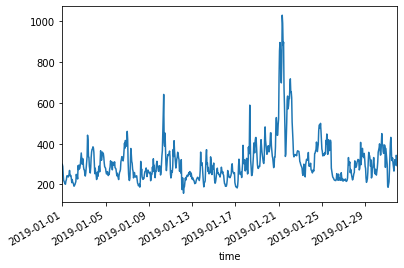

In [103]:
airquality_indexed.loc["2019-1"].value.plot()

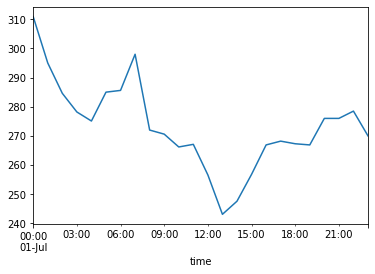

In [104]:
airquality_indexed.loc["2019-07-01"].value.plot()

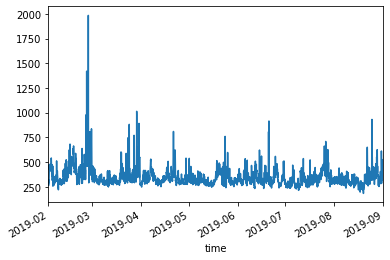

In [105]:
airquality_indexed.truncate(before='2019-02-01', after='2019-09-01').value.plot()

## 3. Computing statistics

The indexed dataframe allows to compute statistics over different timeframes

In [114]:
# you can do simple operations like adding and substraction
print(
    airquality_indexed.loc["2019-01-01 00:00:00"].value - \
    airquality_indexed.loc["2019-01-01 01:00:00"].value
)

10.400000000000034


In [113]:
# calculate the difference between every hour
airquality_indexed.loc["2019-01-01"].value.diff()

time
2019-01-01 00:00:00     NaN
2019-01-01 01:00:00   -10.4
2019-01-01 02:00:00   -43.1
2019-01-01 03:00:00   -24.7
2019-01-01 04:00:00    -5.4
2019-01-01 05:00:00    -6.6
2019-01-01 06:00:00    -5.5
2019-01-01 07:00:00    -1.8
2019-01-01 08:00:00    15.9
2019-01-01 09:00:00     6.7
2019-01-01 10:00:00    18.5
2019-01-01 11:00:00     0.9
2019-01-01 12:00:00    -2.6
2019-01-01 13:00:00    -3.7
2019-01-01 14:00:00     2.5
2019-01-01 15:00:00    11.8
2019-01-01 16:00:00    17.9
2019-01-01 17:00:00   -21.0
2019-01-01 18:00:00    -5.3
2019-01-01 19:00:00     1.7
2019-01-01 20:00:00   -15.5
2019-01-01 21:00:00   -19.9
2019-01-01 22:00:00    15.4
2019-01-01 23:00:00   -12.5
Name: value, dtype: float64

In [112]:
# summing
airquality_indexed.loc["2019-01-01"].value.sum()

5639.700000000001

In [18]:
# take the rolling average of 2 days
ozone.rolling("2D").mean().head(2)

,value,airquality_index
time,,
2019-01-01 00:00:00,30.70,3.0
2019-01-01 01:00:00,39.45,3.5


In [19]:
# expanding is useful for calculating the cumulative sum
ozone.expanding().sum()

,value,airquality_index
time,,
2019-01-01 00:00:00,30.7,3.0
2019-01-01 01:00:00,78.9,7.0
2019-01-01 02:00:00,132.9,11.0
2019-01-01 03:00:00,189.9,15.0
2019-01-01 04:00:00,247.3,19.0
...,...,...
2019-09-30 19:00:00,355348.2,26387.0
2019-09-30 20:00:00,355369.7,26389.0
2019-09-30 21:00:00,355390.5,26391.0


Plot the difference between the hours of January 1st

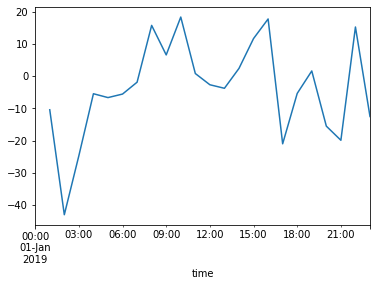

In [118]:
airquality_indexed.loc["2019-01-01"].value.diff().plot()

Try to plot the rolling mean per week for the month of March

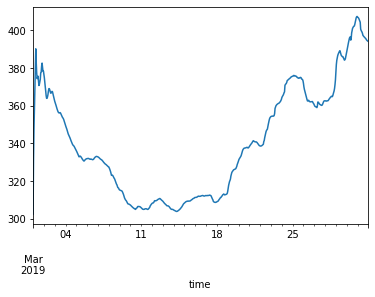

In [125]:
airquality_indexed.loc["2019-03"].value.rolling("7D").mean().plot()

## Shift

With `pandas.DataFrame.shift` you can shift the index by a desired number of periods.

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.shift.html

Try adding a column to the dataframe with the value of 'CO' of the previous hour.
Then plot the two lines!

In [136]:
co_lag_1_day = airquality_indexed.value.shift(periods=1)
co_lag_1_day.name = "value_lag_1"
airquality_with_lag = pd.merge(airquality_indexed, co_lag_1_day, on="time")

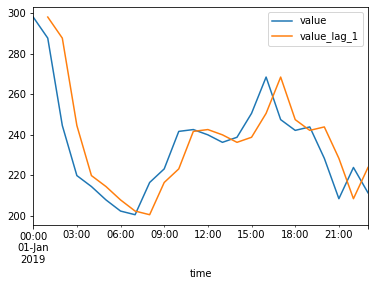

In [140]:
airquality_with_lag.loc["2019-01-01"][["value", "value_lag_1"]].plot()

## Resampling

A convenient method for conversion the frequency of your dataframe is `resampling`.
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.resample.html

In [142]:
# Try to resample the dataframe to a daily frequency by taking the mean.
airquality_indexed.resample("1D").mean()

,value,airquality_index,time_unix
time,,,
2019-01-01,234.987500,1.166667,1.546342e+09
2019-01-02,263.770833,1.541667,1.546429e+09
2019-01-03,323.234783,1.956522,1.546515e+09
2019-01-04,292.600000,1.833333,1.546601e+09
2019-01-05,279.329167,1.916667,1.546688e+09
...,...,...,...
2019-10-31,NaN,NaN,NaN
2019-11-01,NaN,NaN,NaN
2019-11-02,NaN,NaN,NaN


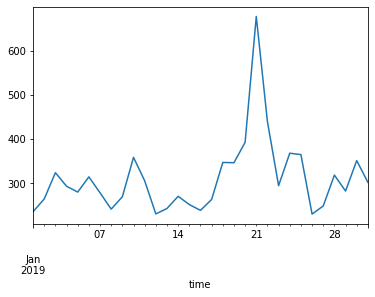

In [149]:
# plot the daily values of 'CO' for January
airquality_indexed.loc["2019-01"].value.resample("1D").mean().plot()

Besides resampling to a lower frequency (downsampling), you can also resample to a higher frequency (upsampling).

In [143]:
# Resample the data to a half-hour frequency, using forward filling
airquality_indexed.resample("0.5H").ffill()

,location,component,value,airquality_index,time_unix
time,,,,,
2019-01-01 00:00:00,Amsterdam-Vondelpark,CO,298.1,2,1.546301e+09
2019-01-01 00:30:00,Amsterdam-Vondelpark,CO,298.1,2,1.546301e+09
2019-01-01 01:00:00,Amsterdam-Vondelpark,CO,287.7,2,1.546304e+09
2019-01-01 01:30:00,Amsterdam-Vondelpark,CO,287.7,2,1.546304e+09
2019-01-01 02:00:00,Amsterdam-Vondelpark,CO,244.6,1,1.546308e+09
...,...,...,...,...,...
2019-11-04 11:00:00,Amsterdam-Vondelpark,CO,266.5,2,1.569884e+09
2019-11-04 11:30:00,Amsterdam-Vondelpark,CO,266.5,2,1.569884e+09
2019-11-04 12:00:00,Amsterdam-Vondelpark,CO,266.5,2,1.569884e+09


In [146]:
# you can also interpolate the missing datapoints by using .interpolate
airquality_indexed.resample("0.5H").interpolate(method="linear")

,location,component,value,airquality_index,time_unix
time,,,,,
2019-01-01 00:00:00,Amsterdam-Vondelpark,CO,298.100000,2.000000,1.546301e+09
2019-01-01 00:30:00,NaN,NaN,292.900000,2.000000,1.546303e+09
2019-01-01 01:00:00,Amsterdam-Vondelpark,CO,287.700000,2.000000,1.546304e+09
2019-01-01 01:30:00,NaN,NaN,266.150000,1.500000,1.546306e+09
2019-01-01 02:00:00,Amsterdam-Vondelpark,CO,244.600000,1.000000,1.546308e+09
...,...,...,...,...,...
2019-11-04 11:00:00,NaN,NaN,186.792530,1.002410,1.572865e+09
2019-11-04 11:30:00,NaN,NaN,186.744398,1.001807,1.572867e+09
2019-11-04 12:00:00,NaN,NaN,186.696265,1.001205,1.572869e+09


Resample the data of January to a half-hour frequency and plot the result using method="linear" and also try other methods such as "spline"

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.interpolate.html

In [164]:
airquality_indexed.loc["2019-01"].resample("0.5H").interpolate(method="linear").value.head()

time
2019-01-01 00:00:00    298.10
2019-01-01 00:30:00    292.90
2019-01-01 01:00:00    287.70
2019-01-01 01:30:00    266.15
2019-01-01 02:00:00    244.60
Freq: 30T, Name: value, dtype: float64

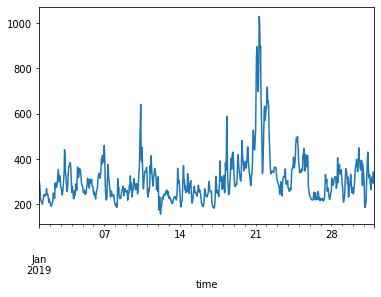

In [165]:
airquality_indexed.loc["2019-01"].resample("0.5H").interpolate(method="linear").value.plot()

In [171]:
airquality_indexed \
    .loc["2019-01"] \
    .resample("0.5H") \
    .interpolate(method="spline", order=2) \
    .value \
    .head()

time
2019-01-01 00:00:00    298.100000
2019-01-01 00:30:00    297.899930
2019-01-01 01:00:00    287.700000
2019-01-01 01:30:00    267.002599
2019-01-01 02:00:00    244.600000
Freq: 30T, Name: value, dtype: float64

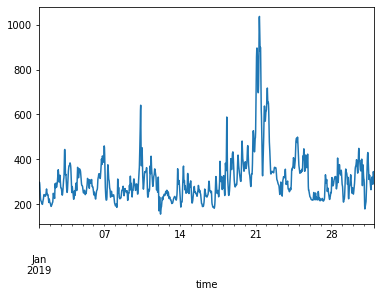

In [172]:
airquality_indexed \
    .loc["2019-01"] \
    .resample("0.5H") \
    .interpolate(method="spline", order=2) \
    .value \
    .plot()

## .dt accessor

You can use the `.dt` accessor to extract information from the date

Overview of all .dt accessors: https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#time-date-components

In [173]:
# Add three columns to the airquality dataframe for day, day of the week, and hour.
airquality["day"] = airquality.time.dt.day
airquality["weekday"] = airquality.time.dt.dayofweek
airquality["hour"] = airquality.time.dt.hour

In [174]:
print(airquality.sample(3))

,time,location,component,value,airquality_index,time_unix,day,weekday,hour
34761,2019-07-28 20:00:00,Amsterdam-Vondelpark,FN,0.16,1,1.564344e+09,28,6,20
2436,2019-01-16 04:00:00,Amsterdam-Vondelpark,O3,62.60,5,1.547611e+09,16,2,4
19230,2019-04-26 13:00:00,Amsterdam-Vondelpark,O3,67.70,5,1.556284e+09,26,4,13


It allows you to do easy filtering as well, for example, select only datapoints where hour == 2

In [176]:
airquality.loc[airquality.time.dt.hour == 2,:].sample(2)

,time,location,component,value,airquality_index,time_unix,day,weekday,hour
17143,2019-04-14 02:00:00,Amsterdam-Vondelpark,NO,-0.2,1,1.555207e+09,14,6,2
19319,2019-04-27 02:00:00,Amsterdam-Vondelpark,NO,0.1,1,1.556330e+09,27,5,2
